# Pumpversuch-Auswertung mit Theis-Recovery-Fit

*Dieses Notebook führt durch die gesamte Auswertung von Druckdaten eines Pumpversuchs am Brunnen 3224 (Campus Holländischer Platz) unter Anwendung der Jacob-Korrektur und Theis-Superpositionsmodell.*

## 1. Daten einlesen und vorbereiten

- Datei einlesen (Metadaten überspringen, ANSI-Encoding)
- Datum und Zeit kombinieren und als Index setzen
- Dezimalkomma in Dezimalpunkt umwandeln

In [1]:
import pandas as pd
import numpy as np

file = 'GWM3224_DK3000-20169_10.06.25_09-27-33.ASC'

data = pd.read_csv(
    file,
    skiprows=5,
    encoding='utf-8',
    sep=r'\s+',
    comment='%',
    header=None,
    names=['date', 'time', 'temperature_C', 'pressure_mbar']
)

data['datetime'] = pd.to_datetime(
    data['date'] + ' ' + data['time'],
    dayfirst=True,
    format='%d.%m.%y %H:%M:%S'
)

data = data.set_index('datetime').drop(columns=['date','time'])

data = data.map(lambda x: x.replace(',','.')).astype(float)

data.head()

,temperature_C,pressure_mbar
datetime,,
2025-06-04 11:00:00,23.1978,992.674
2025-06-04 11:01:00,22.9286,992.407
2025-06-04 11:02:00,15.7473,1319.020
2025-06-04 11:03:00,13.3773,1328.720
2025-06-04 11:04:00,12.8425,1333.750


## 2. Rohdaten-Plot: Druckverlauf

- Druck over time visualisieren
- Major-Ticks alle 6 h, Minor-Ticks alle 1 h

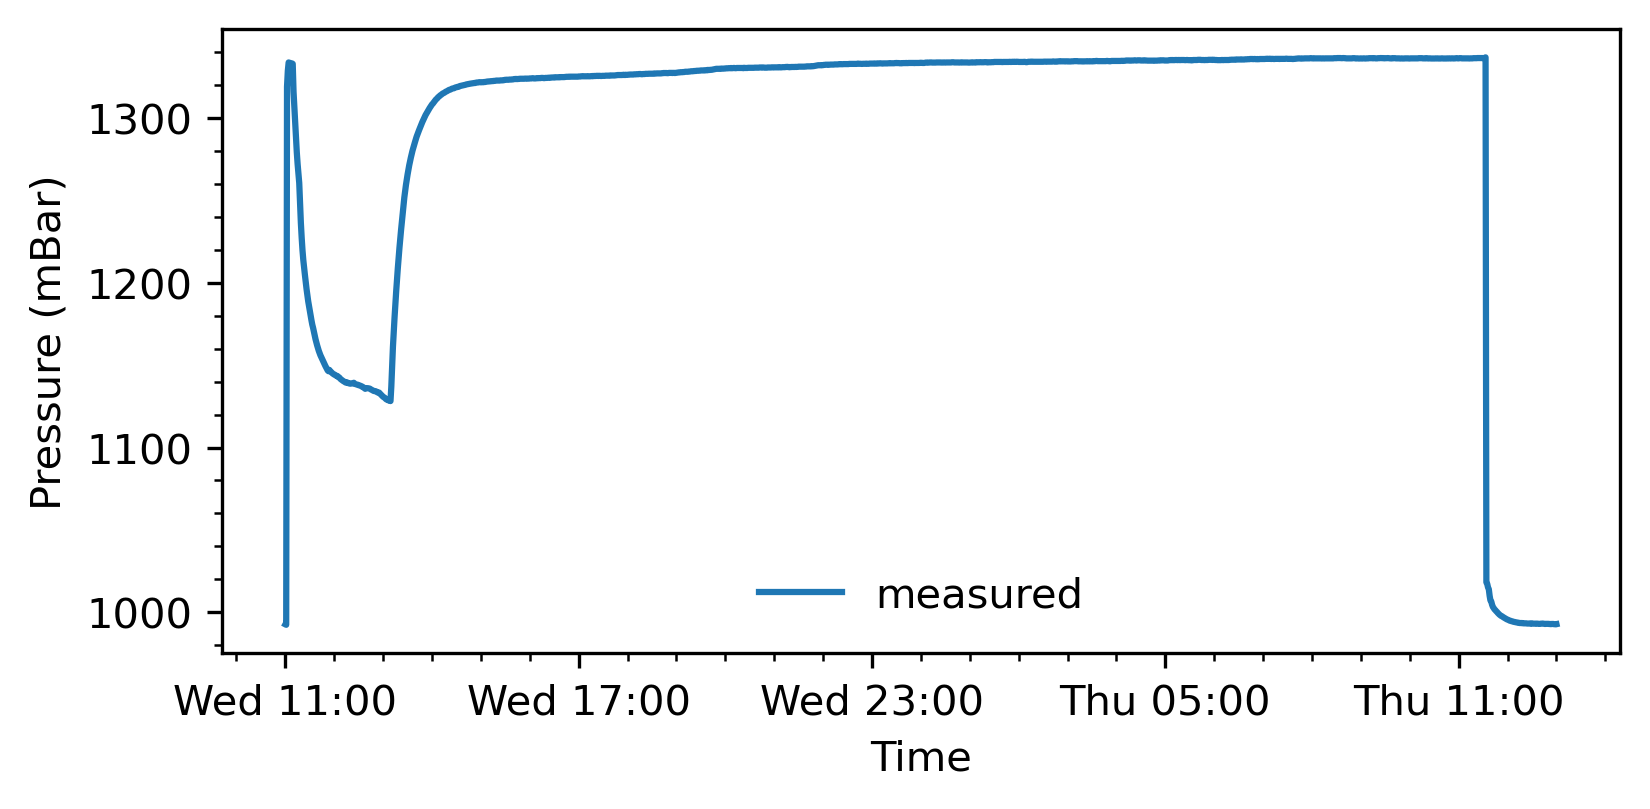

In [2]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(14/2.5, 7/2.5), dpi=300)
ax.plot(data['pressure_mbar'], label='measured')

ax.minorticks_on()
ax.xaxis.set_major_locator(mdates.HourLocator(interval=6))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%a %H:%M'))
ax.xaxis.set_minor_locator(mdates.HourLocator(interval=1))

ax.set_xlabel('Time')
ax.set_ylabel('Pressure (mBar)')
ax.legend(frameon=False, loc='best')
fig.tight_layout()

## 3. Zeitpunkte und Grundparameter bestimmen

- Pumpbeginn, Pumpende, Ende der Erholung ermitteln
- Luft- und Statikdruck berechnen
- Pumpparameter und Aquifer-Geometrie definieren

In [3]:
pump_start   = pd.to_datetime('2025-06-04 11:09:00')
pump_end     = data['pressure_mbar'].loc[pump_start:'2025-06-04 13:30'].idxmin()
recovery_end = data['pressure_mbar'].loc[pump_end:'2025-06-05 13:30'].idxmax()

air_pressure    = data.loc[recovery_end+pd.Timedelta('1min'):,'pressure_mbar'].median()
static_pressure = data.loc[recovery_end-pd.Timedelta('5min'):recovery_end,'pressure_mbar'].median()

pumping_rate      = 2.31 / 1000 / 60  # m3/s
aquifer_thickness = 4.5               # m
theta             = 0.27              # Porosität
r_c               = 0.075             # m, Brunnenradius
r_w               = 0.145             # m, Bohrlochradius
r_ce = np.sqrt((1-theta)*r_c**2 + theta*r_w**2)

print(f"Pumpbeginn: {pump_start}\nPumpende: {pump_end}\nErholung endet: {recovery_end}")
print(f"Luftdruck: {air_pressure:.2f} mbar, Statikdruck: {static_pressure:.2f} mbar")

Pumpbeginn: 2025-06-04 11:09:00
Pumpende: 2025-06-04 13:09:00
Erholung endet: 2025-06-05 11:33:00
Luftdruck: 993.48 mbar, Statikdruck: 1336.42 mbar


## 4. Pump- und Erholungsphase extrahieren & Drawdown berechnen

- Zeiten seit Pumpbeginn (`t_p`) und seit Pumpende (`t_r`) in s
- Raw Drawdown aus Druckdifferenz
- Jacob-Korrektur für ungespannte Aquifere

In [4]:
pdata = data.loc[pump_start:recovery_end].copy()

pdata['t_p'] = (pdata.index - pump_start).total_seconds()
pdata['t_r'] = (pdata.index - pump_end).total_seconds()
pdata.loc[pdata.index <= pump_end, 't_r'] = 0

pdata['drawdown_m'] = (
    (pdata['pressure_mbar'] - air_pressure)*100/9.81/1000
    - (static_pressure - air_pressure)*100/9.81/1000
).abs()

pdata['corr_drawdown_m'] = pdata['drawdown_m'] - (
    pdata['drawdown_m']**2 / (2 * aquifer_thickness)
)

pdata.head()

,temperature_C,pressure_mbar,t_p,t_r,drawdown_m,corr_drawdown_m
datetime,,,,,,
2025-06-04 11:09:00,12.4597,1332.95,0.0,0.0,0.035372,0.035233
2025-06-04 11:10:00,12.4615,1316.05,60.0,0.0,0.207645,0.202855
2025-06-04 11:11:00,12.4597,1306.62,120.0,0.0,0.303772,0.293519
2025-06-04 11:12:00,12.4542,1296.74,180.0,0.0,0.404485,0.386307
2025-06-04 11:13:00,12.4396,1287.13,240.0,0.0,0.502446,0.474396


## 5. Theis-Recovery-Fit vorbereiten

- Nur `t_p > 0` verwenden
- Modellfunktion definieren
- `curve_fit` zur Parameterschätzung

In [6]:
mask = pdata['t_p'] > 0
t_p = pdata.loc[mask,'t_p'].values
d_obs = pdata.loc[mask,'corr_drawdown_m'].values

from scipy.special import exp1
from scipy.optimize import curve_fit

def theis_recovery_model(t_p, T, S):
    """
    Theis-Superpositionsmodell für Pump- und Erholungsphase.
    t : Zeit seit Pumpbeginn [s]
    T : Transmissivität [m2/s]
    S : Speicherkoeffizient [-]
    """
    # Stelle sicher, dass t_p ein numpy-Array ist
    t_p = np.asarray(t_p, dtype=float)
    
    # Erholungszeiten: Null bis pump_end, ansonsten t_p - t_end
    t_r = np.zeros_like(t_p)
    end_tp = pdata.loc[pump_end, 't_p']
    recovery_mask = t_p > end_tp
    t_r[recovery_mask] = t_p[recovery_mask] - end_tp
    
    # u1 und u2
    u1 = r_ce**2 * S / (4 * T * t_p)
    u2 = np.zeros_like(u1)
    u2[recovery_mask] = r_ce**2 * S / (4 * T * t_r[recovery_mask])
    
    # Brunnenfunktion W(u) über Exponentialintegral
    W1 = exp1(u1)
    W2 = np.zeros_like(W1)
    W2[recovery_mask] = exp1(u2[recovery_mask])
    
    # Modellierter Drawdown
    return pumping_rate / (4 * np.pi * T) * (W1 - W2)

initial = [1e-5,1e-4]
params, cov = curve_fit(theis_recovery_model, t_p, d_obs, p0=initial)
T_fit, S_fit = params
print(f"T_fit={T_fit:.2e}, S_fit={S_fit:.2e}")

T_fit=9.97e-06, S_fit=6.06e-02


## 6. Ergebnisse plotten (semi-log)

- Empirische Daten als Scatter
- Gefittete Theis-Kurve (rot)
- Minor-Ticks einschalten

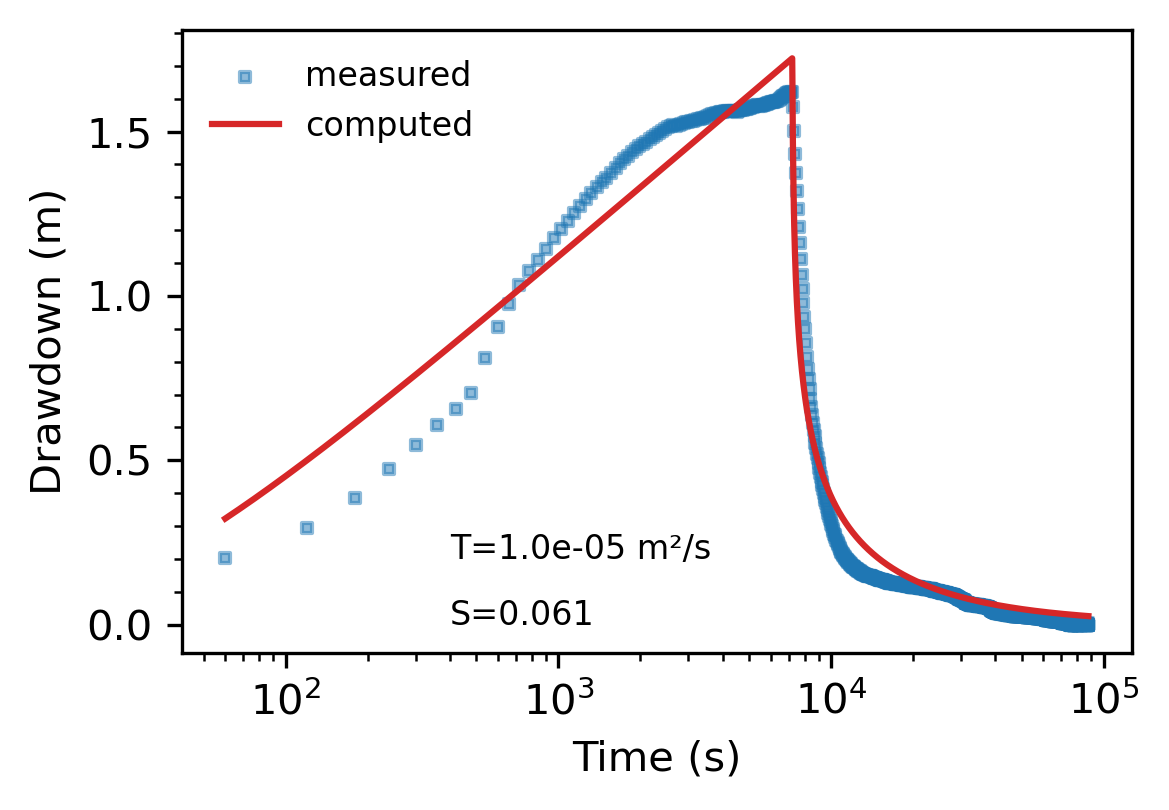

In [7]:
fig, ax = plt.subplots(figsize=(10/2.5, 7/2.5), dpi=300)
ax.scatter(pdata['t_p'], pdata['corr_drawdown_m'], s=5, marker='s', alpha=0.5, label='measured')
t = np.geomspace(60, pdata['t_p'].max(),10000)
ax.plot(t, theis_recovery_model(t, T_fit, S_fit), color='tab:red', label='computed')
ax.set_xscale('log')
ax.minorticks_on()
ax.set_xlabel('Time (s)')
ax.set_ylabel('Drawdown (m)')
ax.text(4e2,0.2, f'T={T_fit:.1e} m²/s', fontsize=8)
ax.text(4e2,0, f'S={S_fit:.3f}', fontsize=8)
ax.legend(frameon=False, loc='upper left', fontsize=8)
fig.tight_layout()